In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Load data
train = pd.read_csv('../data/train.csv', index_col='ex_id')
val = pd.read_csv('../data/dev.csv', index_col='ex_id')
test = pd.read_csv('../data/test_no_label.csv', index_col='ex_id')

### Some explore

In [3]:
# common users in train & val
val[val['user_id'].isin(train['user_id'])]

,user_id,prod_id,rating,label,date,review
ex_id,,,,,,
17,940,0,4.0,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich..."
20,943,0,5.0,0,2014-05-24,Some good Big Greek cooking!! Came to City on ...
30,953,0,4.0,0,2013-10-17,So... as you may notice from some of my other ...
43,966,0,3.0,0,2012-12-19,"I don't understand the whole ""You can't order ..."
53,976,0,5.0,0,2012-05-31,YUMS! I just tried the Carp Roe and it's soooo...
...,...,...,...,...,...,...
358813,18011,921,4.0,0,2012-09-30,This review is only for their Happy Hour. 2 f...
358827,2230,921,5.0,0,2012-06-08,The cat's out of the bag! Bijan's is no longer...
358840,3504,921,5.0,0,2012-01-25,"Ever since Bijan's opened up, happy days are h..."


In [4]:
# users only in val but not trian
val[~val['user_id'].isin(train['user_id'])]

,user_id,prod_id,rating,label,date,review
ex_id,,,,,,
11,934,0,5.0,1,2014-01-20,"all around good place, cozy, I came in and did..."
56,979,0,4.0,0,2012-04-11,"Delicious. Get there early for a seat, or bet..."
65,988,0,3.0,0,2011-12-13,Snack is an adorable little restaurant. It is ...
246,1169,1,5.0,1,2011-01-23,Best Pizza in Brooklyn. I tried others and I h...
254,1177,1,5.0,0,2014-12-08,Delicious food and great customer service! Wil...
...,...,...,...,...,...,...
358850,161112,349,3.0,1,2014-04-09,"The staff was incredibly nice, the lemonade ta..."
358855,161115,349,3.0,0,2014-12-15,"Okay, so I gotta repeat the chorus here and st..."
358859,161116,349,2.0,0,2014-12-10,"The pizza is delicious, but it's SO loud here,..."


In [5]:
# all products are in train data
val[~val['prod_id'].isin(train['prod_id'])]

,user_id,prod_id,rating,label,date,review
ex_id,,,,,,


---

### Construct ALS Dataset

In [6]:
from surprise import SVD
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [7]:
# SELECT user_id, prod_id, rating FROM train WHERE label = 0
train = train[(train['label'] == 0)][['user_id', 'prod_id', 'rating']]
val = val[(val['label'] == 0)][['user_id', 'prod_id', 'rating']]

In [9]:
# Get train data
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order)
data = Dataset.load_from_df(train[['user_id', 'prod_id', 'rating']], reader)

In [10]:
# Get val data
testset = list(zip(val['user_id'].values, val['prod_id'].values, val['rating'].values))

### My Algo

In [11]:
import numpy as np
from surprise import AlgoBase
from surprise import SVD
from surprise import PredictionImpossible


class MyAlgo(SVD):

    def __init__(self, n_factors=100, n_epochs=20, biased=False, 
                 lr_all=.005, reg_all=.02, random_state=None, verbose=False):

        SVD.__init__(self, n_factors=n_factors, n_epochs=n_epochs, 
                     biased=biased, lr_all=lr_all, reg_all=reg_all, 
                     random_state=random_state, verbose=verbose)

    def fit(self, trainset):

        SVD.fit(self, trainset)

        return self

    def estimate(self, u, i):

        known_user = self.trainset.knows_user(u)
        known_item = self.trainset.knows_item(i)

        if known_user and known_item:

            if self.biased:
                est = self.trainset.global_mean
                if known_user:
                    est += self.bu[u]

                if known_item:
                    est += self.bi[i]

                if known_user and known_item:
                    est += np.dot(self.qi[i], self.pu[u])

            else:
                est = np.dot(self.qi[i], self.pu[u])    

        else:
            est = 0
            raise PredictionImpossible('User and item are unknown.')

        return est
    
    def test(self, testset, clip=False, verbose=False):
        predictions = [self.predict(uid,
                                    iid,
                                    r_ui_trans,
                                    clip=clip,
                                    verbose=verbose)
                       for (uid, iid, r_ui_trans) in testset]
        return predictions

### Workplace

In [162]:
rank = 25
reg = 0.1

algo = MyAlgo(n_factors=rank, reg_all=reg, biased=True,
              lr_all=0.005, n_epochs=30, verbose=False, random_state=None)

svd_algo.fit(data.build_full_trainset())

predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)

### Hyperparameter search

#### 1. Rough search

In [8]:
# Rough search
rank_list = [50, 100, 200, 400]
reg_list = [0.001, 0.01, 0.1, 1]
result = {}

for rank in rank_list:
    for reg in reg_list:
        print(f'Training with rank {rank} and reg {reg}')
        algo = MyAlgo(n_factors=rank, reg_all=reg, biased=True, 
                      lr_all=0.005, n_epochs=30, 
                      verbose=False, random_state=None)
        algo.fit(data.build_full_trainset())
        predictions = algo.test(testset)
        rmse = accuracy.rmse(predictions)
        if rank in result:
            result[rank].append(rmse)
        else:
            result[rank] = [rmse]

Training with rank 50 and reg 0.001
RMSE: 2.5056
Training with rank 50 and reg 0.01
RMSE: 2.4957
Training with rank 50 and reg 0.1
RMSE: 2.4844
Training with rank 50 and reg 1
RMSE: 2.4846
Training with rank 100 and reg 0.001
RMSE: 2.5074
Training with rank 100 and reg 0.01
RMSE: 2.4973
Training with rank 100 and reg 0.1
RMSE: 2.4845
Training with rank 100 and reg 1
RMSE: 2.4846
Training with rank 200 and reg 0.001
RMSE: 2.5079
Training with rank 200 and reg 0.01
RMSE: 2.4986
Training with rank 200 and reg 0.1
RMSE: 2.4851
Training with rank 200 and reg 1
RMSE: 2.4847
Training with rank 400 and reg 0.001
RMSE: 2.5092
Training with rank 400 and reg 0.01
RMSE: 2.4988
Training with rank 400 and reg 0.1
RMSE: 2.4852
Training with rank 400 and reg 1
RMSE: 2.4847


In [9]:
result

{50: [2.50558803642059,
  2.49567799785937,
  2.4843796467492125,
  2.4846404448195814],
 100: [2.507441625598193,
  2.4973318284376087,
  2.4844840757625017,
  2.484645917399874],
 200: [2.5079431127181975,
  2.4985780286319463,
  2.485124047347146,
  2.484651014332843],
 400: [2.5092319414125166,
  2.498780883117305,
  2.485241939598439,
  2.484655639705102]}

#### 2. Zoom in, from 1 to 50 inclusive

In [12]:
# Further zoom in
rank_list = list(range(1, 51)) # from 1 to 50 inclusive
reg = 0.1
result = []

for rank in rank_list:
    print(f'Training with rank {rank} and reg {reg}')
    algo = MyAlgo(n_factors=rank, reg_all=reg, biased=True, 
                      lr_all=0.005, n_epochs=30, 
                      verbose=False, random_state=None)
    algo.fit(data.build_full_trainset())
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    result.append(rmse)

Training with rank 1 and reg 0.1
RMSE: 1.0066
Training with rank 2 and reg 0.1
RMSE: 1.0066
Training with rank 3 and reg 0.1
RMSE: 1.0066
Training with rank 4 and reg 0.1
RMSE: 1.0067
Training with rank 5 and reg 0.1
RMSE: 1.0066
Training with rank 6 and reg 0.1
RMSE: 1.0067
Training with rank 7 and reg 0.1
RMSE: 1.0066
Training with rank 8 and reg 0.1
RMSE: 1.0067
Training with rank 9 and reg 0.1
RMSE: 1.0069
Training with rank 10 and reg 0.1
RMSE: 1.0067
Training with rank 11 and reg 0.1
RMSE: 1.0069
Training with rank 12 and reg 0.1
RMSE: 1.0067
Training with rank 13 and reg 0.1
RMSE: 1.0070
Training with rank 14 and reg 0.1
RMSE: 1.0070
Training with rank 15 and reg 0.1
RMSE: 1.0067
Training with rank 16 and reg 0.1
RMSE: 1.0068
Training with rank 17 and reg 0.1
RMSE: 1.0072
Training with rank 18 and reg 0.1
RMSE: 1.0070
Training with rank 19 and reg 0.1
RMSE: 1.0067
Training with rank 20 and reg 0.1
RMSE: 1.0066
Training with rank 21 and reg 0.1
RMSE: 1.0070
Training with rank 22 

In [13]:
result

[1.0065858928462104,
 1.0065926850630968,
 1.006636414168308,
 1.0066737879576302,
 1.0065865819343343,
 1.0066500195041854,
 1.006609087718492,
 1.0066777283339858,
 1.0069250328050499,
 1.00666742110498,
 1.006888706101609,
 1.0066712036244563,
 1.0070231198488602,
 1.0069782730986534,
 1.006737271006093,
 1.0068418670076618,
 1.0071690955525252,
 1.0069824648711028,
 1.0067037278702178,
 1.006639682963319,
 1.0070283615013034,
 1.0067126438620932,
 1.0074184148674015,
 1.0068476152749433,
 1.007039131387743,
 1.0065748838274151,
 1.007233932776915,
 1.006977771574749,
 1.0068708884084268,
 1.0070250815019575,
 1.0071581760587982,
 1.0071225535993775,
 1.0071529659453915,
 1.0069323959071907,
 1.0071094512114203,
 1.0072246222053634,
 1.0076287990077557,
 1.0071382958151804,
 1.0075597126592386,
 1.00735459110865,
 1.0070285122803517,
 1.0070719348246295,
 1.0075644617050314,
 1.0072139339826043,
 1.0070446995269107,
 1.0074942654928747,
 1.0066954390884508,
 1.0073520396497906,
 1.0

In [14]:
import matplotlib.pyplot as plt

Best rank is 26, RMSE is 1.0065748838274151


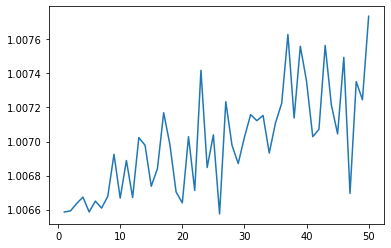

In [15]:
plt.plot(rank_list, result)
print(f'Best rank is {rank_list[result.index(min(result))]}, RMSE is {min(result)}')
plt.show()